# Steps to apply density based outlier removal

This method is implemented based on the LOF2 method proposed in this article https://opengeospatialdata.springeropen.com/articles/10.1186/s40965-018-0056-5

### 1. Load packages

In [1]:
import os, sys, datetime, shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.neighbors as nn
import scipy.stats as stats
from statsmodels import robust
from sklearn import preprocessing
from sklearn.cluster import OPTICS
import hdbscan

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

ModuleNotFoundError: No module named 'hdbscan'

In [3]:
path_in = "D:/Projects/Tribus_project/tests/nki_cycif/input_data" # note the slash is in UNIX form
filenames=os.listdir(path_in)
print(filenames)

['TMA_18_810_cellTypes.csv', 'TMA_34_504_cellTypes.csv']


## Test for one file

In [4]:
samplefile = filenames[0]
input_path = os.path.join(path_in,samplefile)
data_input = pd.read_csv(input_path)

In [25]:
df = data_input[data_input.Inside_ROI == 0]
df

,Row_number,CoreId,CellId,DNA1,BG488,BG555,BG647,DNA2,CD11c,CD207,...,Eccentricity,Solidity,Perimeter,Roundness,X_position,Y_position,lost,Inside_ROI,GlobalCellType,out_of_core
0,0,100,1,3000.303030,907.954545,467.803030,1520.333333,1840.742424,655.151515,873.272727,...,0.290195,0.985075,26.614,1.170937,869.151515,95.363636,False,0,Stromal,Inside.core
1,1,100,2,7147.951220,1348.203252,433.780488,1445.788618,4649.520325,892.235772,1118.804878,...,0.716599,0.960938,38.291,1.054196,911.048780,95.430894,False,0,Stromal,Inside.core
2,2,100,3,11127.016529,1338.280992,409.776860,1482.198347,7460.876033,881.975207,1177.454545,...,0.628134,0.975806,37.431,1.085256,921.950413,97.297521,False,0,Stromal,Inside.core
3,3,100,4,7277.044118,1079.713235,516.286765,1459.183824,4980.132353,764.198529,1123.448529,...,0.644473,0.931507,41.450,0.994717,934.794118,98.132353,False,0,Stromal,Inside.core
4,4,100,5,3532.065934,696.571429,280.868132,1147.373626,2336.945055,571.362637,655.945055,...,0.428384,0.989130,31.088,1.183221,1065.901099,100.054945,False,0,Stromal,Inside.core
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765800,779634,9,9586,4995.435000,755.184800,217.260900,1019.554000,2931.250000,893.826100,723.173900,...,0.625744,0.978723,31.576,1.159534,1861.620000,2339.152000,False,0,Stromal,Inside.core
765801,779635,9,9587,27756.240000,1250.779000,404.022900,1220.885000,16772.710000,1970.687000,1408.954000,...,0.442473,0.970370,37.646,1.161565,1755.672000,2340.733000,False,0,Lymphoid2,Inside.core
765802,779636,9,9588,18038.490000,1322.504000,673.254400,1521.991000,10789.080000,962.258800,1515.763000,...,0.738995,0.966102,52.814,1.027180,1770.794000,2346.535000,False,0,Stromal,Inside.core
765803,779637,9,9589,17387.180000,795.502400,288.952200,1199.627000,10340.800000,1199.407000,6044.321000,...,0.543184,0.976635,49.382,1.077008,1691.086000,2347.330000,False,0,Myeloid.cells,Inside.core


In [18]:
print(set(data_input.lost))
print(set(data_input.Inside_ROI))
print(set(data_input.GlobalCellType))
print(set(data_input.out_of_core))

{False}
{0, 1}
{'Myeloid.cells', 'Stromal', 'Lymphoid2', 'InsideROI', 'LowDapi', 'Tumor', 'Other', 'Lymphoid1'}
{'Inside.core'}


#### This part is only if you don't know the files

In [7]:
# Uncomment to see the column names in the input
#print(data_input.columns)

# This is the list of features that are used for cell to cell similarity
CHANNEL_COLNAMES = ['DNA1', 'BG488', 'BG555', 'BG647',
       'DNA2', 'CD11c', 'CD207', 'GranzymeB', 'DNA3', 'CD163', 'CD57', 'CD20',
       'DNA4', 'CD4', 'CD3d', 'CD8a', 'DNA5', 'TIM3', 'pSTAT1', 'DNA6',
       'CD45RO', 'FOXP3', 'PD1', 'DNA7', 'pTBK1', 'CD68', 'PDL1_2', 'DNA8',
       'CD15', 'CD11b', 'yH2AX', 'DNA9', 'PDL1_488', 'PDL1_555', 'cPARP1',
       'DNA10', 'Ki67', 'Vimentin', 'MHCII', 'DNA11', 'LaminB1', 'CK7', 'MHCI',
       'DNA12', 'ECadherin', 'aSMA', 'CD31', 'Area']
META_COLNAMES = ['Row_number', 'CoreId', 'CellId', 'X_position', 'Y_position', 'lost', 'Inside_ROI', 'GlobalCellType',
       'out_of_core']
UNUSED_COLNAMES = ['MajorAxisLength',
       'MinorAxisLength', 'Eccentricity', 'Solidity', 'Perimeter', 'Roundness']


In [26]:
array_data = df[CHANNEL_COLNAMES].to_numpy()
log_data = np.log1p(array_data)

In [8]:
array_data = data_input[CHANNEL_COLNAMES].to_numpy()
log_data = np.log1p(array_data)
scaled_data = preprocessing.RobustScaler().fit(log_data).transform(log_data)

array([1, 1, 1, ..., 1, 1, 1])

In [27]:
# This computes the outlier score 765196
clf = nn.LocalOutlierFactor(n_jobs=18, n_neighbors=30, algorithm='kd_tree')
clf.fit_predict(log_data)

array([1, 1, 1, ..., 1, 1, 1])

<AxesSubplot:ylabel='Density'>

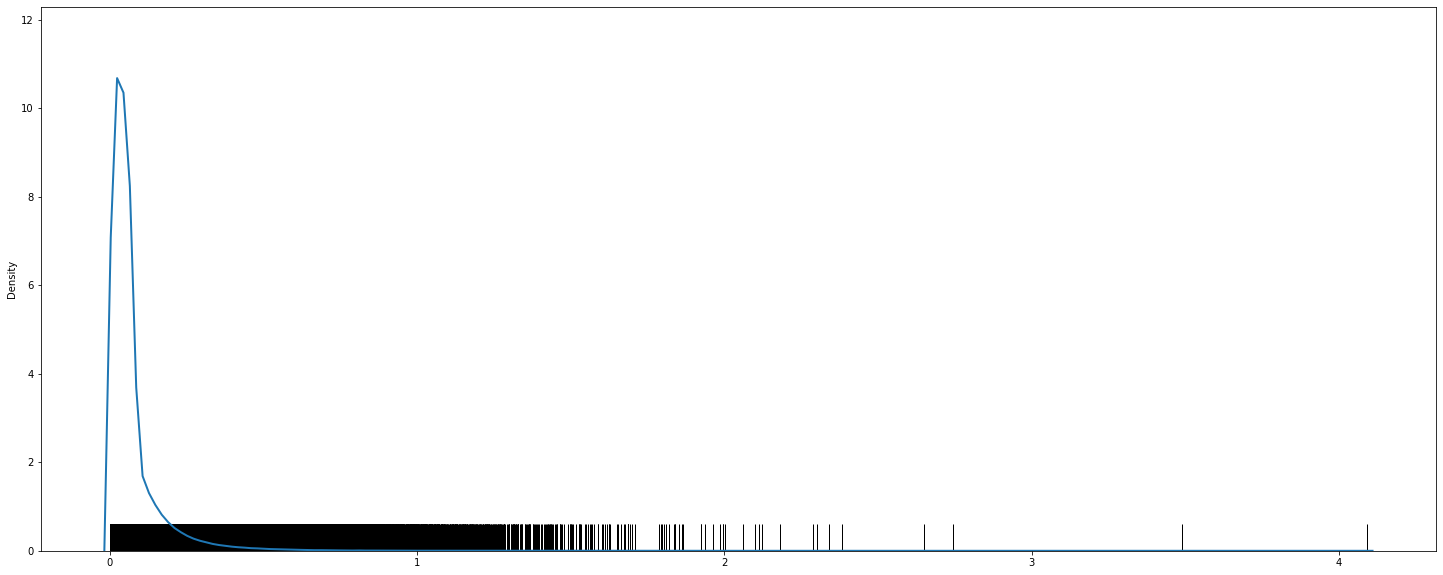

In [28]:
s = clf.negative_outlier_factor_
mad_lof = abs(s - np.median(s))
plt.subplots(figsize=(25,10))
sns.distplot(a=mad_lof, hist=False, kde=True, rug=True,
    rug_kws={'height': .05, 'color': 'black'},
    kde_kws={'linewidth': 2})

In [44]:
clust = OPTICS(min_samples=50, xi=0.05, min_cluster_size=0.05, n_jobs=18)
clust.fit(scaled_data)

KeyboardInterrupt: 

In [34]:
print(len(mad_lof))
df['LOF2'] = mad_lof

765196


<ipython-input-34-390aabdd1394>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LOF2'] = mad_lof


In [37]:
core10 = df[df.CoreId == 10]

<AxesSubplot:xlabel='LOF2', ylabel='Density'>

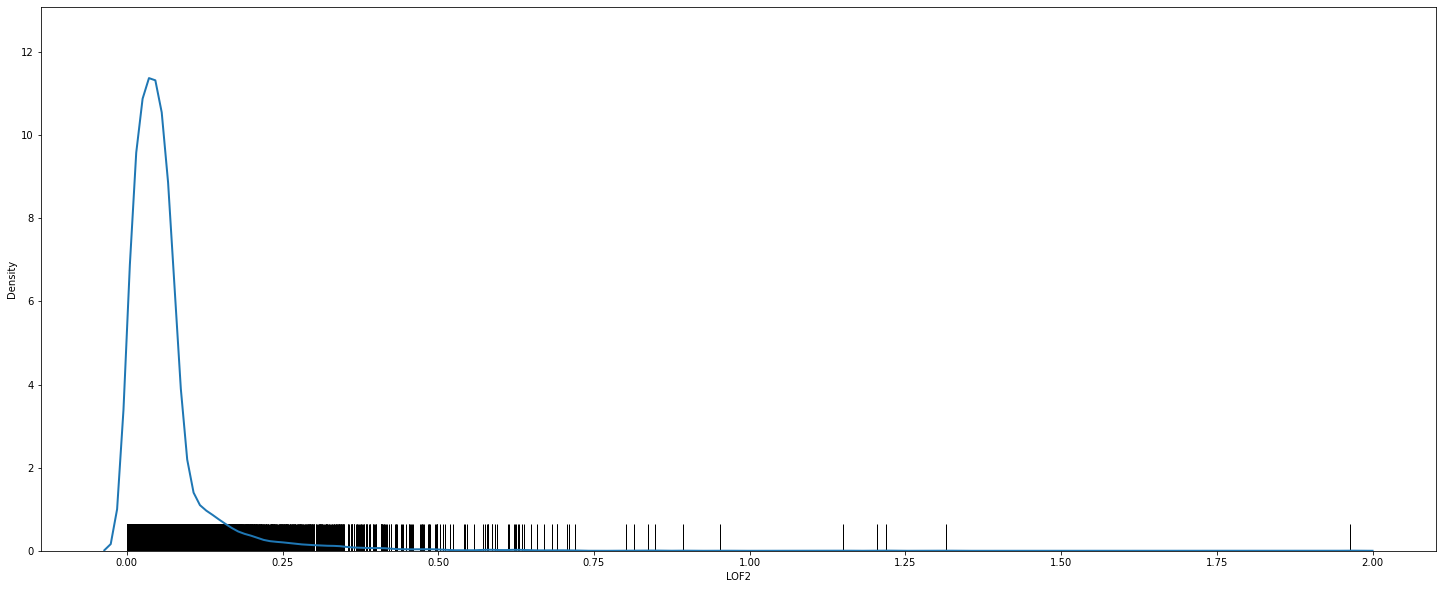

In [39]:
plt.subplots(figsize=(25,10))
sns.distplot(a=core10.LOF2, hist=False, kde=True, rug=True,
    rug_kws={'height': .05, 'color': 'black'},
    kde_kws={'linewidth': 2})

In [40]:
core10.to_csv(os.path.join(path_in,'core10_with_LOF2_score.csv'))

Without scaling factor


In [ ]:
# This computes the outlier score
clf = nn.LocalOutlierFactor(n_jobs=18, n_neighbors=30, algorithm='kd_tree')
clf.fit_predict(scaled_data)

## Test HDBScan

* Is it faster than OPTIC clustering?
* Is it more accurate than SOM?
* How to automatically select sensible parameters?
* Can we reuse parts of the call for LOF2 computation?

In [ ]:
## HDBscan 

## Run for all files

In [ ]:
lof_by_sample = []
i = 0
for samplefile in filenames:
    input_path = os.path.join(path_in,samplefile)
    print(input_path)
    data_input = pd.read_csv(input_path)
    array_data = data_input[CHANNEL_COLNAMES].to_numpy()
    log_data = np.log1p(array_data)
    scaled_data = preprocessing.RobustScaler().fit(log_data).transform(log_data)
    # This computes the 
    clf = nn.LocalOutlierFactor(n_jobs=18, n_neighbors=30, algorithm='kd_tree')
    clf.fit_predict(scaled_data)
    lof_by_sample.append(clf.negative_outlier_factor_)